Import necessary packages

In [4]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import requests, zipfile, io, os
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Import libraries for machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [37]:
#!pip install seaborn
#import seaborn as sns
import matplotlib.pyplot as plt

Set directory to write and read files

In [7]:
data_directory = "Cancer_datasets"
headers = {
    'Connection': 'keep-alive',
    'Host': 'static-content.springer.com',
    'Referer': 'https://www.nature.com/',
    'Upgrade-Insecure-Requests': '1',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0',
    'Accept-Language': 'en-US,en;q=0.5'
}
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.2810/MediaObjects/41592_2014_BFnmeth2810_MOESM206_ESM.zip'
request = requests.get(url, headers=headers, stream=True)
zip_reader = zipfile.ZipFile(io.BytesIO(request.content))
zip_reader.extractall(data_directory)

In [9]:
os. getcwd()

'/home/abhinandan/Downloads/AR_Lab/Cancer'

Preprocessing

In [8]:
cancer_types = ["Breast", "Colon", "GBM", "Lung"]
breast_gene_exp_df = pd.read_csv(
    "{}/Breast/BREAST_Gene_Expression.txt".format(data_directory),
    delimiter=r"\s+", index_col=0)
colon_gene_exp_df = pd.read_csv(
    "{}/Colon/COLON_Gene_Expression.txt".format(data_directory), 
    delimiter=r"\s+", index_col=0) 
gbm_gene_exp_df = pd.read_csv(
    "{}/GBM/GLIO_Gene_Expression.txt".format(data_directory), 
    delimiter=r"\s+", index_col=0) 
lung_gene_exp_df = pd.read_csv(
    "{}/Lung/LUNG_Gene_Expression.txt".format(data_directory), 
    delimiter=r"\s+", index_col=0)

In [10]:
genes_breast = set(breast_gene_exp_df.index)
genes_colon = set(colon_gene_exp_df.index)
genes_gdm = set(gbm_gene_exp_df.index)
genes_lung = set(lung_gene_exp_df.index)
genes_found_in_all_sets = genes_breast.intersection(
    genes_colon).intersection(
    genes_gdm).intersection(
    genes_lung)
print(f"Number of common genes: {len(genes_found_in_all_sets)}")

Number of common genes: 11925


In [11]:
exp_df = pd.DataFrame()
for df, cancer_type in zip([breast_gene_exp_df, colon_gene_exp_df, 
                            gbm_gene_exp_df, lung_gene_exp_df],
                            cancer_types):
    transposed_df = pd.DataFrame(df.reindex(genes_found_in_all_sets).transpose())
    transposed_df["cancer_type"] = cancer_type
    exp_df = pd.concat([exp_df, transposed_df])
exp_df.to_csv("expression.csv.bz2")

In [12]:
X = exp_df.drop(["cancer_type"], axis=1).values
targets = exp_df["cancer_type"].values
X_train, X_test, y_train, y_test = train_test_split(X, targets, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest Model

In [13]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.9076923076923077


Support Vector Machine Model

In [14]:
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_accuracy = svm_model.score(X_test_scaled, y_test)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.6307692307692307


Neural Network Model

In [15]:
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_accuracy = nn_model.score(X_test_scaled, y_test)
nn_predictions = nn_model.predict(X_test_scaled)
print(f"Neural Network Accuracy: {nn_accuracy}")

Neural Network Accuracy: 0.5769230769230769


Report

In [16]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Neural Network'],
    'Accuracy': [rf_accuracy, svm_accuracy, nn_accuracy]
})
print(results_df)

            Model  Accuracy
0   Random Forest  0.907692
1             SVM  0.630769
2  Neural Network  0.576923


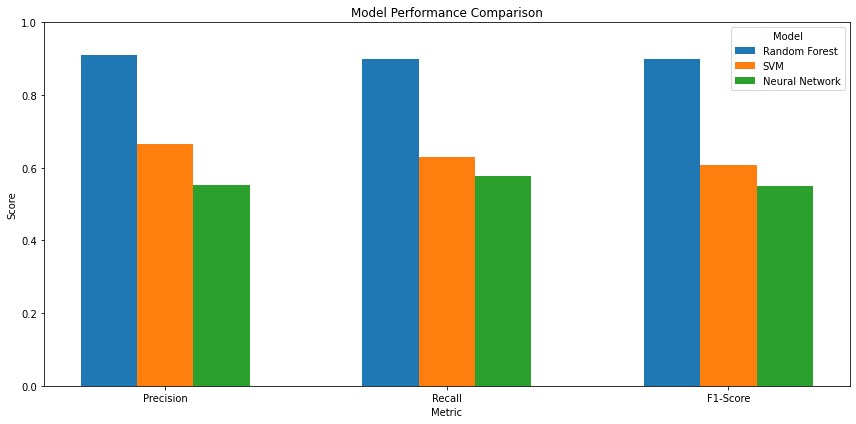

In [39]:
rf_report = classification_report(y_test, rf_model.predict(X_test_scaled), output_dict=True)
svm_report = classification_report(y_test, svm_model.predict(X_test_scaled), output_dict=True)
nn_report = classification_report(y_test, nn_predictions, output_dict=True)

performance_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Random Forest': [rf_report['weighted avg']['precision'], rf_report['weighted avg']['recall'], rf_report['weighted avg']['f1-score']],
    'SVM': [svm_report['weighted avg']['precision'], svm_report['weighted avg']['recall'], svm_report['weighted avg']['f1-score']],
    'Neural Network': [nn_report['weighted avg']['precision'], nn_report['weighted avg']['recall'], nn_report['weighted avg']['f1-score']]
})

performance_melted = performance_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Set up the figure
plt.figure(figsize=(12, 6))

# Get unique metrics and models for plotting
metrics = performance_melted['Metric'].unique()
models = performance_melted['Model'].unique()
x = np.arange(len(metrics))  # X-axis positions for the groups
width = 0.2  # Width of the bars

# Plot bars for each model
for i, model in enumerate(models):
    model_data = performance_melted[performance_melted['Model'] == model]
    plt.bar(x + i * width, model_data['Score'], width=width, label=model)

# Add labels, title, and adjust ticks
plt.xticks(x + width, metrics)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.show()